In [86]:
import pandas as pd
import numpy as np

# Graphing
from graph_config import plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

#stats
from statsmodels.tsa.seasonal import STL

import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET_PATH = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


| Column Name                    | Data Type  | Unit | Description                                                                  |
| ------------------------------ | ---------- | ---- | ---------------------------------------------------------------------------- |
| `Timestamp`                    | `datetime` | -    | Timestamp of the observation (30-minute frequency).                          |
| `Power_kw`                     | `float`    | kW   | Actual power output from the turbine (baseline telemetry).                   |
| `Setpoint_kw`                  | `float`    | kW   | Target or allowed power output set by turbine controller or grid signal.     |
| `Baseline_wind_ms`             | `float`    | m/s  | Measured wind speed from the turbine sensor (baseline).                      |
| `Scrape_wind_ms`               | `float`    | m/s  | Wind speed scraped from a weather data source.                               |
| `scraped_interpolated`         | `boolean`  | -    | `True` if the scraped wind value was filled via short-gap interpolation.     |
| `baseline_interpolated`        | `boolean`  | -    | `True` if the baseline wind value was filled via short-gap interpolation.    |
| `Scrape_linear_scaled_wind_ms` | `float`    | m/s  | Scraped wind corrected using a linear regression model.                      |
| `Final_wind_ms`                | `float`    | m/s  | Final selected wind speed (baseline or corrected scraped).                   |
| `Wind_data_source`             | `string`   | -    | Source of `Final_wind_ms`: `"baseline"` or `"scraped"`.                      |
| `Predicted_power_kw`           | `float`    | kW   | Power estimated from `Final_wind_ms` using a Weibull power model.            |
| `Final_power_kw`               | `float`    | kW   | Final selected power: either `Power_kw` or filled from `Predicted_power_kw`. |
| `Power_data_source`            | `string`   | -    | Source of `Final_power_kw`: `"baseline"`, `"predicted"`, or `"turbine_off"`. |
| `Energy_kWh`                   | `float`    | kWh  | Energy output during the 30-minute interval (`Final_power_kw × 0.5`).        |

In [26]:
# Load turbine telemetry dataset
ts_tt = pd.read_csv(PROCESSED_DATASET_PATH / '250411_turbine_telemetry_dataset_v1.csv', index_col=0)
ts_tt.head()

# set NaN values in Final_power_kw and Energy_kWh to 0
ts_tt['Final_power_kw'] = ts_tt['Final_power_kw'].fillna(0)
ts_tt['Energy_kWh'] = ts_tt['Energy_kwh'].fillna(0) 

In [29]:
# load residential demand dataset
ts_rd = pd.read_csv(PROCESSED_DATASET_PATH / '250411_residential_demand_dataset_v1.csv', index_col=0)
ts_rd.head()

,Demand_mean_kw,N_households,Energy_kwh_per_household,Energy_kwh_total,Season,Hour,Day
Timestamp,,,,,,,
2017-01-01 00:00:00,0.220106,5428,0.110053,597.3690,Winter,0,2017-01-01
2017-01-01 00:30:00,0.205945,5429,0.102973,559.0380,Winter,0,2017-01-01
2017-01-01 01:00:00,0.189090,5429,0.094545,513.2845,Winter,1,2017-01-01
2017-01-01 01:30:00,0.173118,5429,0.086559,469.9290,Winter,1,2017-01-01
2017-01-01 02:00:00,0.159051,5429,0.079525,431.7430,Winter,2,2017-01-01


In [30]:
ts_rd.shape, ts_tt.shape

((17568, 7), (17568, 14))

## Merge Datasetr

In [95]:
ts_combined = ts_tt.merge(
    ts_rd,
    how='inner',
    left_index=True,
    right_index=True,
    suffixes=('_tt', '_rd')
)

ts_combined.index = pd.to_datetime(ts_combined.index)
ts_combined.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,...,Power_data_source,Energy_kwh,Energy_kWh,Demand_mean_kw,N_households,Energy_kwh_per_household,Energy_kwh_total,Season,Hour,Day
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,...,baseline,444.883333,444.883333,0.220106,5428,0.110053,597.3690,Winter,0,2017-01-01
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,...,baseline,446.633333,446.633333,0.205945,5429,0.102973,559.0380,Winter,0,2017-01-01
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,...,baseline,448.816667,448.816667,0.189090,5429,0.094545,513.2845,Winter,1,2017-01-01
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,...,baseline,449.983333,449.983333,0.173118,5429,0.086559,469.9290,Winter,1,2017-01-01
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,...,baseline,450.000000,450.000000,0.159051,5429,0.079525,431.7430,Winter,2,2017-01-01


# Curtailment

In [98]:
N_turbine = 150
Max_export = 40 # MWh
Max_export_kwh = Max_export * 1000 # kWh

ts_combined['Total_turbine_energy_kwh'] = ts_combined['Energy_kwh'] * N_turbine

ts_combined['Exportable_kwh'] = (ts_combined['Total_turbine_energy_kwh'] - ts_combined['Energy_kwh_total']).clip(lower=0)

ts_combined['Exported_kwh'] = ts_combined['Exportable_kwh'].clip(upper=Max_export_kwh)

ts_combined['Curtailment_kwh'] = (ts_combined['Total_turbine_energy_kwh'] - ts_combined['Energy_kwh_total'] - ts_combined['Exported_kwh']).clip(lower=0)

ts_combined.head()

,Power_kw,Setpoint_kw,Baseline_wind_ms,Scrape_wind_ms,scraped_interpolated,baseline_interpolated,Scrape_linear_scaled_wind_ms,Final_wind_ms,Wind_data_source,Predicted_power_kw,...,N_households,Energy_kwh_per_household,Energy_kwh_total,Season,Hour,Day,Total_turbine_energy_kwh,Exportable_kwh,Exported_kwh,Curtailment_kwh
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,889.766667,900.0,13.820000,10.28,True,False,15.871210,13.820000,baseline,861.539133,...,5428,0.110053,597.3690,Winter,0,2017-01-01,66732.5,66135.1310,40000.0,26135.1310
2017-01-01 00:30:00,893.266667,900.0,16.106667,10.28,False,False,15.871210,16.106667,baseline,896.305704,...,5429,0.102973,559.0380,Winter,0,2017-01-01,66995.0,66435.9620,40000.0,26435.9620
2017-01-01 01:00:00,897.633333,900.0,16.380000,9.39,False,False,14.691604,16.380000,baseline,897.370495,...,5429,0.094545,513.2845,Winter,1,2017-01-01,67322.5,66809.2155,40000.0,26809.2155
2017-01-01 01:30:00,899.966667,900.0,17.083333,9.83,False,False,15.274780,17.083333,baseline,898.971498,...,5429,0.086559,469.9290,Winter,1,2017-01-01,67497.5,67027.5710,40000.0,27027.5710
2017-01-01 02:00:00,900.000000,900.0,16.800000,7.15,False,False,11.722710,16.800000,baseline,898.481853,...,5429,0.079525,431.7430,Winter,2,2017-01-01,67500.0,67068.2570,40000.0,27068.2570


New Column

| Column Name                    | Data Type  | Unit | Description                                                                  |
| ------------------------------ | ---------- | ---- | ---------------------------------------------------------------------------- |
| `Total_turbine_energy_kwh`     | `float`    | kWh  | Cumulative energy generated by all turbine                                   |
| `Exportable_kwh`               | `float`    | kWh  | Amount of energy that could be exported to the grid.                         |
| `Exported_kwh`                 | `float`    | kWh  | Actual energy exported to the grid.                                          |
| `Curtailment_kwh` | `float`   | kWh  | **Excess generated energy that could not be used by households or exported to the grid. Calculated as:** `max(Energy_kWh - Energy_kwh_total - Exported_kwh, 0)` |



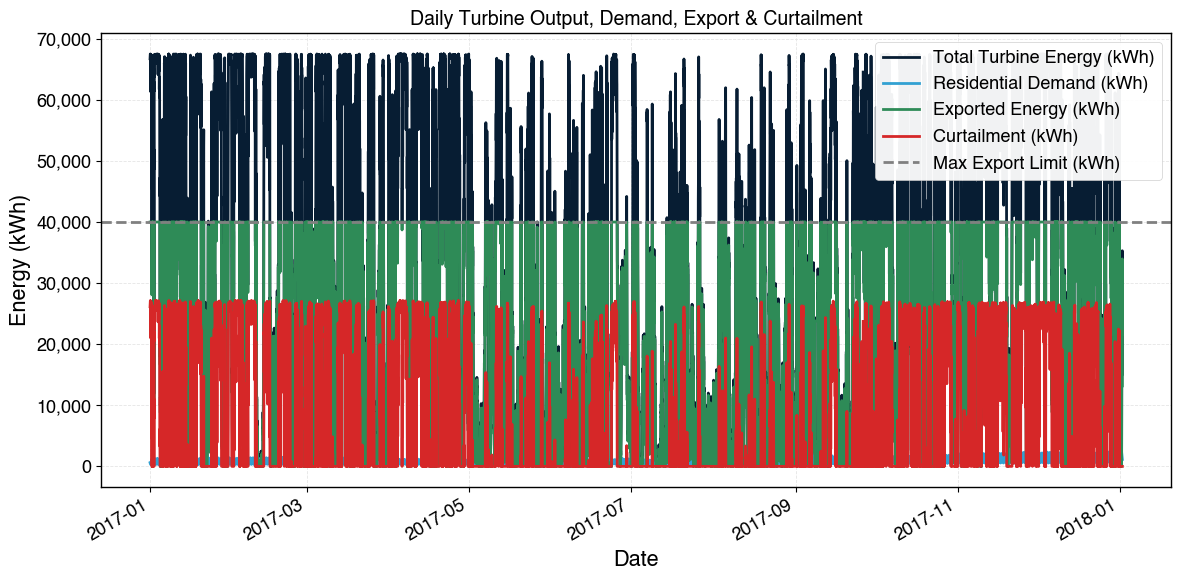

In [87]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ts_combined.index, ts_combined['Total_turbine_energy_kwh'], '-', color='#071D33', label='Total Turbine Energy (kWh)')
ax.plot(ts_combined.index, ts_combined['Energy_kwh_total'], '-', color='#32A1D2', label='Residential Demand (kWh)')
ax.plot(ts_combined.index, ts_combined['Exported_kwh'], '-', color='#2E8B57', label='Exported Energy (kWh)')  # SeaGreen
ax.plot(ts_combined.index, ts_combined['Curtailment_kwh'], '-', color='#D62728', label='Curtailment (kWh)')  # Red
ax.axhline(y=Max_export_kwh, color='gray', linestyle='--', label='Max Export Limit (kWh)')

ax.set_title('Daily Turbine Output, Demand, Export & Curtailment')

# Format y-axis with comma-separated thousands
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Date')
ax.set_ylabel('Energy (kWh)')
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()



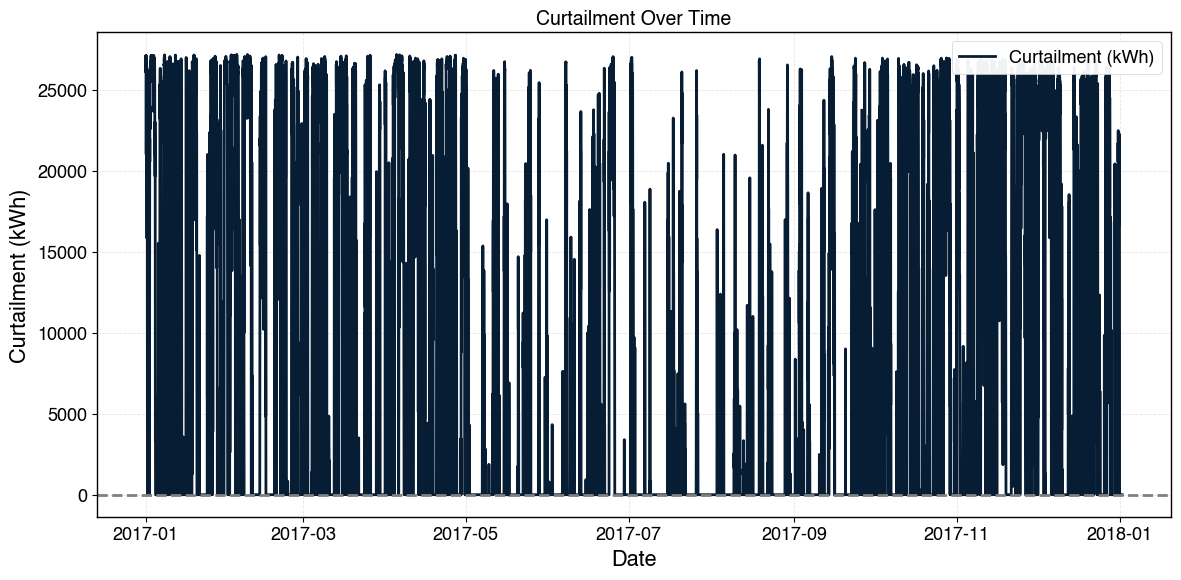

In [88]:
# Plot Curtailment
plt.figure(figsize=(12, 6))
plt.plot(ts_combined.index, ts_combined['Curtailment_kwh'], '-', label='Curtailment (kWh)')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Curtailment Over Time')
plt.xlabel('Date')
plt.ylabel('Curtailment (kWh)')
plt.legend()
plt.tight_layout()
plt.show()

## Analysis

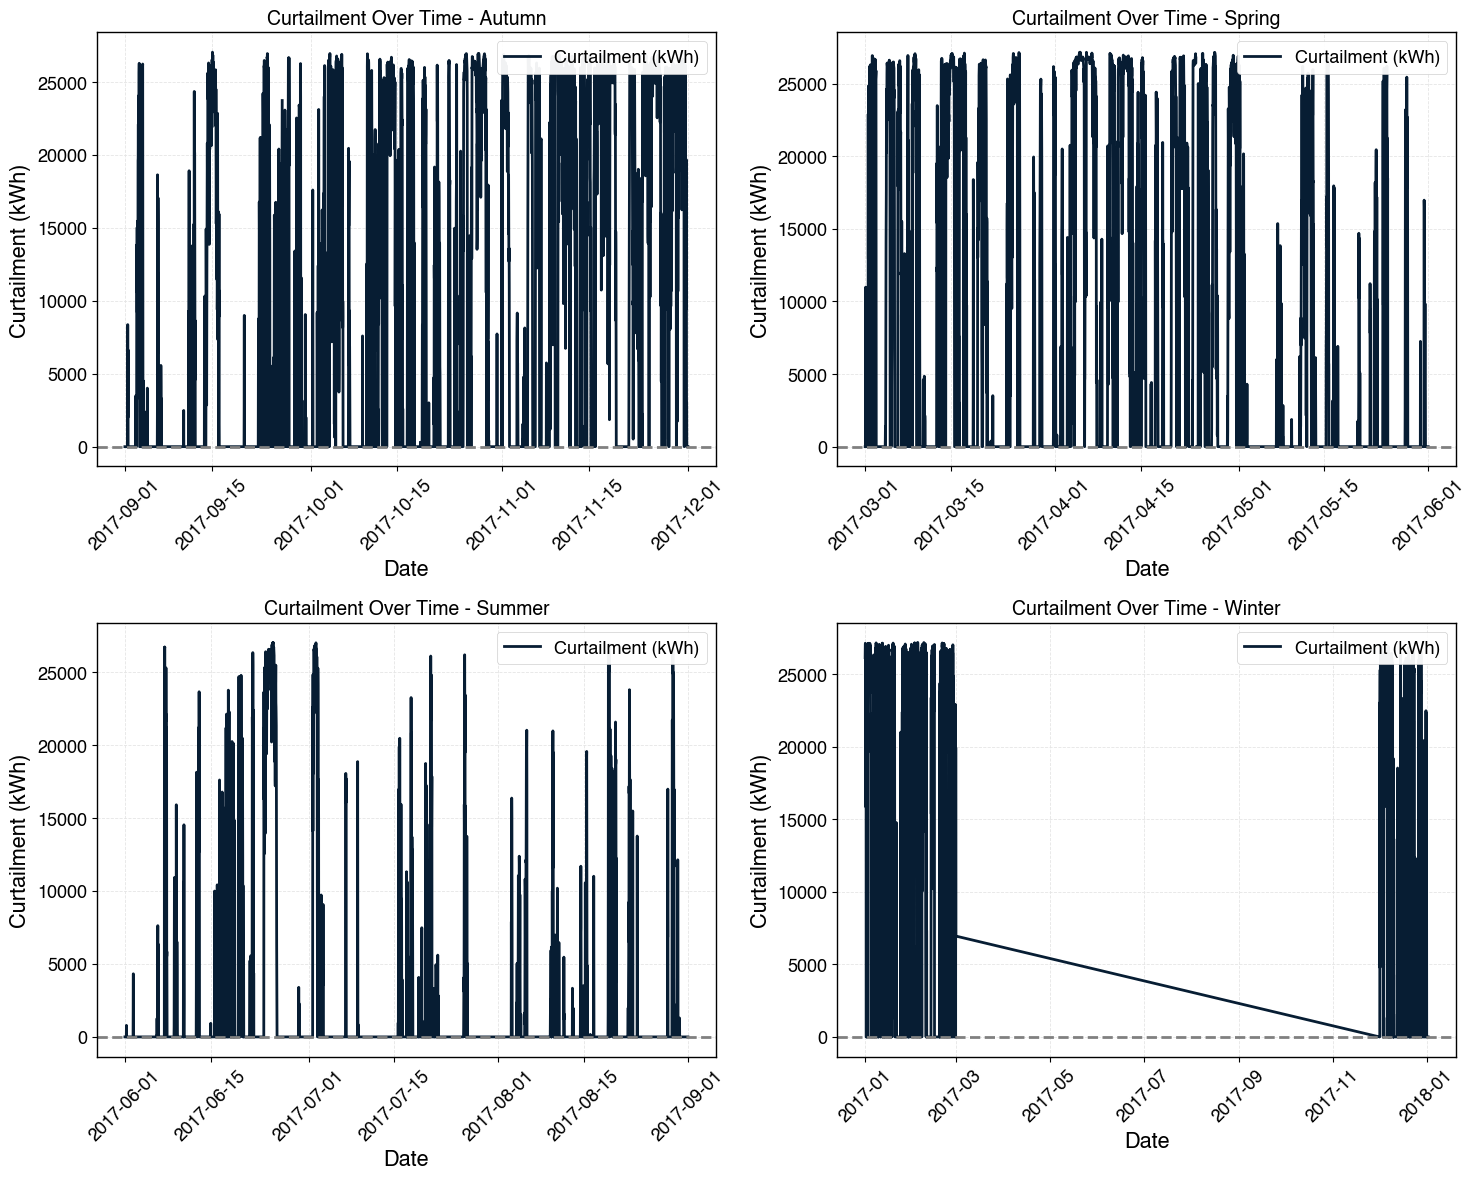

In [91]:
# Curtailment Over different season
seasons = sorted(ts_rd['Season'].unique())  # Optional: sort seasons for consistent order
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=False)

for i, season in enumerate(seasons):
    row, col = i // 2, i % 2
    ts_season = ts_combined[ts_combined['Season'] == season]
    
    axs[row, col].plot(ts_season.index, ts_season['Curtailment_kwh'], '-', label='Curtailment (kWh)')
    axs[row, col].axhline(y=0, color='gray', linestyle='--')
    axs[row, col].set_title(f'Curtailment Over Time - {season}', fontsize=14)
    axs[row, col].set_xlabel('Date')
    # roate x-axis labels
    axs[row, col].tick_params(axis='x', rotation=45)
    axs[row, col].set_ylabel('Curtailment (kWh)')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Average Curtailment by Hour'}, xlabel='Hour'>

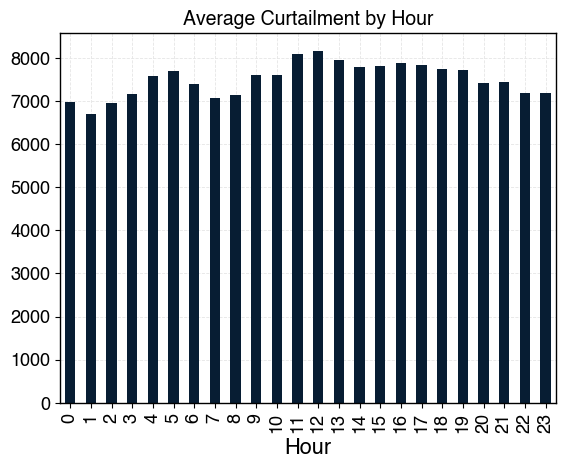

In [92]:
ts_combined.groupby('Hour')['Curtailment_kwh'].mean().plot(kind='bar', title='Average Curtailment by Hour')


| Model No. | Input Rating (+5%/-10%) | Output Rating | Boost Mode Rating | Maximum Storage Capacity (Wh) |
|-----------|--------------------------|----------------|-------------------|-------------------------------|
| QM050RF   | 1020W                   | 500W           | 340W              | 7140                          |
| QM070RF   | 1560W                   | 700W           | 520W              | 10920                         |
| QM100RF   | 2220W                   | 1000W          | 740W              | 15540                         |
| QM125RF   | 2760W                   | 1250W          | 920W              | 19320                         |
| QM150RF   | 3300W                   | 1500W          | 1100W             | 23100                         |


Max Quantum Heater 